In [35]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve

In [51]:
dataset = pd.read_csv('datasets\story_emotion2.csv', encoding='ISO-8859-1')
stemmer = pd.read_csv('datasets\stem_tl.csv')
word_to_stem = dict(zip(stemmer['word'], stemmer['stem']))

replace_patterns = {
    re.compile(r"\bngayo\'y\b"): 'ngayon ay',
    re.compile(r"\bhangga\'t\b"): 'hanggang',
    re.compile(r"\b\'?y\b"): ' ay',
    re.compile(r"\b\'?t\b"): ' at',
    re.compile(r"\b\'?yan\b"): 'iyan',
    re.compile(r"\b\'?yo\b"): 'iyo',
    re.compile(r"\b\'?yon\b"): 'iyon',
    re.compile(r"\b\'?yun\b"): 'iyun',
    re.compile(r"\b\'?pagkat\b"): 'sapagkat',
    re.compile(r"\b\'?di\b"): 'hindi',
    re.compile(r"\b\'?kaw\b"): "ikaw",
    re.compile(r"\b\'?to\b"): 'ito',
    re.compile(r"\b\'?wag\b"): 'huwag',
    re.compile(r"\bgano\'n\b"): 'ganoon'
}

class_names = {
    1: 'fear',
    2: 'anger',
    3: 'joy',
    4: 'sadness',
    5: 'disgust',
    6: 'surprise'
}

display(dataset.head())

,text,emotion
0,"Masusunog kami, Bathala! Tulungan mo kami! sig...",1
1,Paano tayo makararating sa sanggol?,1
2,Lalong ayaw niya ang isang Hari na mas mataas ...,1
3,"May masamang balak si Herodes sa sanggol, baba...",1
4,Takot na takot ako.,1


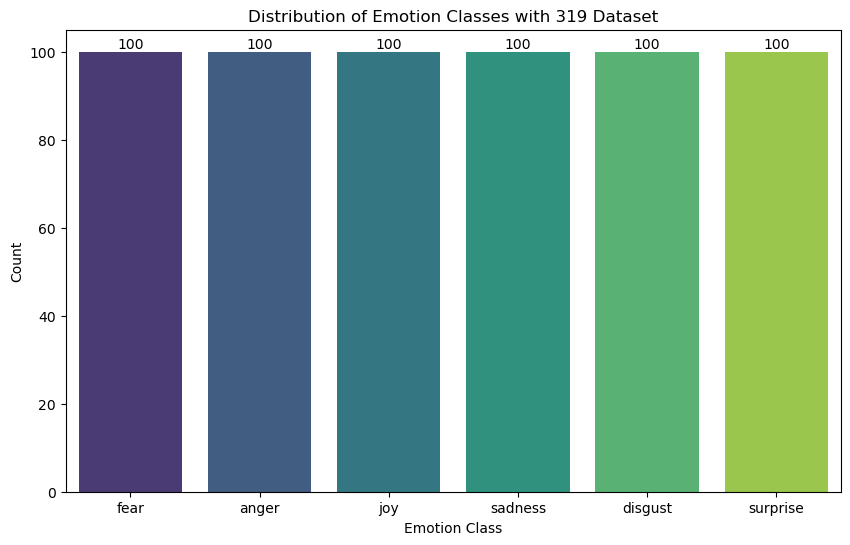

In [52]:
class_counts = dataset['emotion'].value_counts()

plt.figure(figsize=(10, 6))
sns.countplot(x='emotion', data=dataset, order=class_counts.index, palette='viridis')

plt.title('Distribution of Emotion Classes with 319 Dataset')
plt.xlabel('Emotion Class')
plt.ylabel('Count')

plt.xticks(ticks=np.arange(len(class_counts)), labels=[class_names[i] for i in class_counts.index])

for i, count in enumerate(class_counts):
    plt.text(i, count + 0.1, str(count), ha='center', va='bottom')

plt.show()

In [53]:
def data_preprocess(text, replace_patterns, word_to_stem):
    text = text.lower()

    for pattern, replacement in replace_patterns.items():
        text = pattern.sub(replacement, text)

    text = re.sub("[^a-zA-Z\s?!.]", '', text)
    tokens = word_tokenize(text)
    text = ' '.join([word_to_stem.get(word, word) for word in tokens])

    return text

dataset['text_preprocessed'] = dataset['text'].apply(data_preprocess, replace_patterns=replace_patterns, word_to_stem=word_to_stem)

display(dataset.head(10))

,text,emotion,text_preprocessed
0,"Masusunog kami, Bathala! Tulungan mo kami! sig...",1,sunog kami bathala ! tulong mo kami ! sigaw ng...
1,Paano tayo makararating sa sanggol?,1,paano tayo dating sa sanggol ?
2,Lalong ayaw niya ang isang Hari na mas mataas ...,1,lalo ayaw niya ang isa hari na mas taas at kap...
3,"May masamang balak si Herodes sa sanggol, baba...",1,may sama balak si herodes sa sanggol babala ng...
4,Takot na takot ako.,1,takot na takot ako .
5,Mula noon ay lalong hindi siya makatingin Sa m...,1,mula noon ay lalo hindi siya tingin sa mga man...
6,Lagi siya sa isang sulok. Inaantok. Sumisingho...,1,lagi siya sa isa sulok . antok . singhot . bal...
7,Hindi ako takot sa dilim! habang nanginginig s...,1,hindi ako takot sa dilim ! habang nginig sa takot
8,"Nang makita niya na walang ilaw, nagsisigaw si...",1,nang kita niya na wala ilaw sigaw siya sa takot .
9,Tuka'y tumitiklop Pag nagtangkang tumilaok.,1,tuka ay tiklop pag tangka tilaok .


In [54]:
dataset.to_csv('datasets/1.preprocessed.csv', index=False)

In [55]:
vectorizer = CountVectorizer()
sparse_matrix = vectorizer.fit_transform(dataset['text_preprocessed'])
sparse_matrix.todense()
CountVectorized = pd.DataFrame(sparse_matrix.toarray(), columns=vectorizer.get_feature_names_out())
CountVectorized_result = pd.concat([dataset['text_preprocessed'], CountVectorized], axis=1)

display(CountVectorized_result)

,text_preprocessed,abay,agad,ahas,aiden,akala,akalaing,akin,aking,aklatan,...,yakap,yakapin,yaman,yari,yata,yayakapin,yuck,yuko,yumabong,yung
0,sunog kami bathala ! tulong mo kami ! sigaw ng...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,paano tayo dating sa sanggol ?,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,lalo ayaw niya ang isa hari na mas taas at kap...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,may sama balak si herodes sa sanggol babala ng...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,takot na takot ako .,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,may kita si miguel na isa pulang plastik sa si...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
596,runong ka ring magtanim tay ?,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
597,manghangmangha siya sa kagandahan ng dalaga,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
598,maayos naman siyang sinalubong ng maganak at p...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [56]:
CountVectorized_result.to_csv('datasets/2.CountVectorized.csv', index=False)

In [57]:
tfidf_transformer = TfidfTransformer()
X_tfidf = tfidf_transformer.fit_transform(sparse_matrix)
X_tfidf.todense()
tfidf = pd.DataFrame(X_tfidf.toarray(), columns = vectorizer.get_feature_names_out())
tfidf_result = pd.concat([dataset['text_preprocessed'], tfidf], axis=1)

display(tfidf_result)

,text_preprocessed,abay,agad,ahas,aiden,akala,akalaing,akin,aking,aklatan,...,yakap,yakapin,yaman,yari,yata,yayakapin,yuck,yuko,yumabong,yung
0,sunog kami bathala ! tulong mo kami ! sigaw ng...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,paano tayo dating sa sanggol ?,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,lalo ayaw niya ang isa hari na mas taas at kap...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,may sama balak si herodes sa sanggol babala ng...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,takot na takot ako .,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,may kita si miguel na isa pulang plastik sa si...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
596,runong ka ring magtanim tay ?,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
597,manghangmangha siya sa kagandahan ng dalaga,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
598,maayos naman siyang sinalubong ng maganak at p...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [58]:
tfidf_result.to_csv('datasets/3.TF-IDF.csv', index=False)

In [59]:
X = dataset['text_preprocessed']
Y = dataset['emotion']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", Y_train.shape)
print("y_test shape:", Y_test.shape)

X_train shape: (480,)
X_test shape: (120,)
y_train shape: (480,)
y_test shape: (120,)


In [60]:
train_class_counts = Y_train.value_counts()
print("Training Set Class Distribution:")
print(train_class_counts)

test_class_counts = Y_test.value_counts()
print("\nTesting Set Class Distribution:")
print(test_class_counts)


Training Set Class Distribution:
1    80
6    80
3    80
2    80
4    80
5    80
Name: emotion, dtype: int64

Testing Set Class Distribution:
3    20
1    20
4    20
5    20
6    20
2    20
Name: emotion, dtype: int64


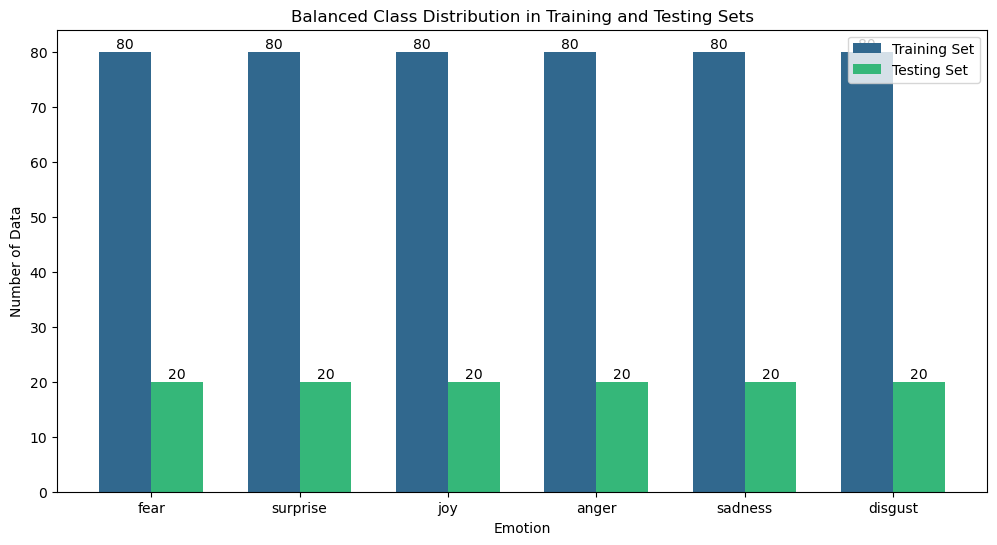

In [61]:
Y_train_names = Y_train.map(class_names)
Y_test_names = Y_test.map(class_names)

train_class_counts = Y_train_names.value_counts()
train_emotions = train_class_counts.index
train_counts = train_class_counts.values

test_class_counts = Y_test_names.value_counts()
test_emotions = test_class_counts.index
test_counts = test_class_counts.values

fig, ax = plt.subplots(figsize=(12, 6))
colors = sns.color_palette('viridis', n_colors=2)
bar_width = 0.35
bar_positions_train = np.arange(len(train_emotions))
bar_positions_test = bar_positions_train + bar_width

ax.bar(bar_positions_train, train_counts, bar_width, label='Training Set', color=colors[0])
ax.bar(bar_positions_test, test_counts, bar_width, label='Testing Set', color=colors[1])

ax.set_xlabel('Emotion')
ax.set_ylabel('Number of Data')
ax.set_title('Balanced Class Distribution in Training and Testing Sets')
ax.set_xticks(bar_positions_train + bar_width / 2)
ax.set_xticklabels(train_emotions)
ax.legend()

for i, count in enumerate(train_counts):
    ax.text(bar_positions_train[i], count, str(count), ha='center', va='bottom')
for i, count in enumerate(test_counts):
    ax.text(bar_positions_test[i], count, str(count), ha='center', va='bottom')

plt.show()

In [62]:
vectorizer = CountVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

print("X_train_vectorized shape:", X_train_vectorized.shape)
print("X_test_vectorized shape:", X_test_vectorized.shape)

X_train_vectorized shape: (480, 1327)
X_test_vectorized shape: (120, 1327)


In [63]:
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_vectorized)
X_test_tfidf = tfidf_transformer.transform(X_test_vectorized)

print("X_train_vectorized shape:", X_train_tfidf.shape)
print("X_test_vectorized shape:", X_test_tfidf.shape)

X_train_vectorized shape: (480, 1327)
X_test_vectorized shape: (120, 1327)


In [64]:
svm = SVC(kernel='linear', C=1, random_state=42)
classifier = OneVsRestClassifier(svm)

cv_results = cross_validate(classifier, X_train_tfidf, Y_train, cv=5, scoring='accuracy', return_train_score=False)
classifier.fit(X_train_tfidf, Y_train)
Y_pred = classifier.predict(X_test_tfidf)

accuracy = accuracy_score(Y_test, Y_pred)
print("Accuracy of Dataset without using \nSentiment Analysis:", accuracy)

print("\nClassification Report:\n", classification_report(Y_test, Y_pred, target_names=class_names.values()))
print("\nCross-Validation Results:")
print("Mean Accuracy:", cv_results['test_score'].mean())
print("Individual Fold Accuracies:", cv_results['test_score'])

Accuracy of Dataset without using 
Sentiment Analysis: 0.38333333333333336

Classification Report:
               precision    recall  f1-score   support

        fear       0.62      0.80      0.70        20
       anger       0.88      0.75      0.81        20
         joy       0.07      0.10      0.08        20
     sadness       0.22      0.20      0.21        20
     disgust       0.42      0.25      0.31        20
    surprise       0.21      0.20      0.21        20

    accuracy                           0.38       120
   macro avg       0.40      0.38      0.39       120
weighted avg       0.40      0.38      0.39       120


Cross-Validation Results:
Mean Accuracy: 0.3708333333333333
Individual Fold Accuracies: [0.27083333 0.36458333 0.34375    0.41666667 0.45833333]


In [16]:
param_grid = {
    'estimator__C': [0.1, 1, 10]
}

grid_search = GridSearchCV(classifier, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_tfidf, Y_train)
best_classifier = grid_search.best_estimator_
Y_pred = best_classifier.predict(X_test_tfidf)

accuracy = accuracy_score(Y_test, Y_pred)
print("Best Parameters:", grid_search.best_params_)
print("Accuracy:", accuracy)
print("\nClassification Report:\n", classification_report(Y_test, Y_pred))

Best Parameters: {'estimator__C': 10}
Accuracy: 0.35833333333333334

Classification Report:
               precision    recall  f1-score   support

           1       0.62      0.80      0.70        20
           2       0.81      0.65      0.72        20
           3       0.07      0.10      0.09        20
           4       0.21      0.20      0.21        20
           5       0.33      0.20      0.25        20
           6       0.20      0.20      0.20        20

    accuracy                           0.36       120
   macro avg       0.37      0.36      0.36       120
weighted avg       0.37      0.36      0.36       120



In [135]:
svm = SVC(kernel='linear', C=1, random_state=42)
classifier = OneVsRestClassifier(svm)

cv_results = cross_validate(classifier, X_train_tfidf, Y_train, cv=5, scoring='accuracy', return_train_score=False)
classifier.fit(X_train_tfidf, Y_train)
Y_pred = classifier.predict(X_test_tfidf)

accuracy = accuracy_score(Y_test, Y_pred)
print("Accuracy of Linear SVM in One vs All Approach \nwith 1200 Data Size:", accuracy)

print("\nClassification Report:\n", classification_report(Y_test, Y_pred, target_names=class_names.values()))
print("\nCross-Validation Results:")
print("Mean Accuracy:", cv_results['test_score'].mean())
print("Individual Fold Accuracies:", cv_results['test_score'])

Accuracy of Linear SVM in One vs All Approach 
with 1200 Data Size: 0.8625

Classification Report:
               precision    recall  f1-score   support

        fear       0.94      0.85      0.89        40
       anger       0.92      0.85      0.88        40
         joy       0.75      0.75      0.75        40
     sadness       0.74      0.88      0.80        40
     disgust       0.95      0.93      0.94        40
    surprise       0.90      0.93      0.91        40

    accuracy                           0.86       240
   macro avg       0.87      0.86      0.86       240
weighted avg       0.87      0.86      0.86       240


Cross-Validation Results:
Mean Accuracy: 0.803125
Individual Fold Accuracies: [0.76041667 0.83854167 0.81770833 0.83333333 0.765625  ]


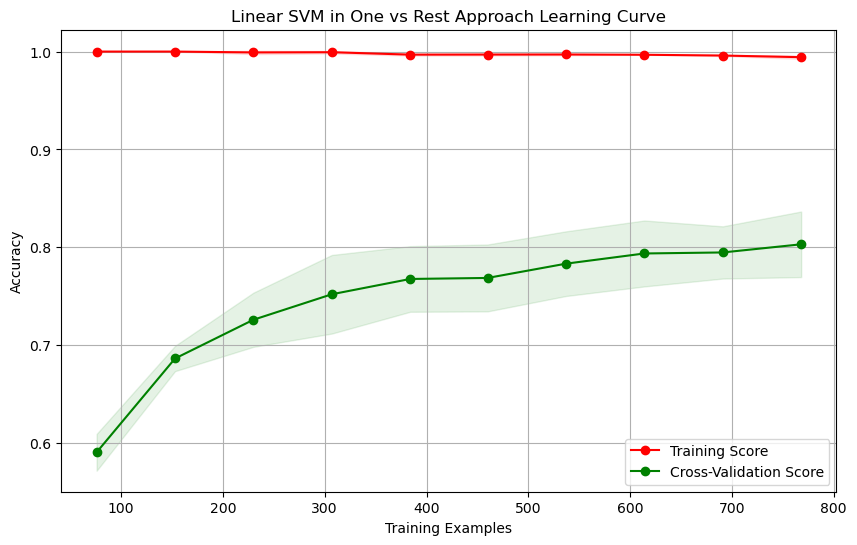

In [80]:
train_sizes, train_scores, test_scores = learning_curve(
    classifier, X_train_tfidf, Y_train, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10), random_state=42
)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.title("Linear SVM in One vs Rest Approach Learning Curve")
plt.xlabel("Training Examples")
plt.ylabel("Accuracy")

plt.grid()
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training Score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-Validation Score")

plt.legend(loc="best")
plt.show()


In [101]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

# K-Fold Cross-Validation loop
for fold, (train_index, test_index) in enumerate(skf.split(X, Y)):
    X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
    Y_train_fold, Y_test_fold = Y.iloc[train_index], Y.iloc[test_index]

    # Data preprocessing and vectorization for each fold
    X_train_vectorized_fold = vectorizer.fit_transform(X_train_fold)
    X_test_vectorized_fold = vectorizer.transform(X_test_fold)

    X_train_tfidf_fold = tfidf_transformer.fit_transform(X_train_vectorized_fold)
    X_test_tfidf_fold = tfidf_transformer.transform(X_test_vectorized_fold)

    # SVM classifier for each fold
    svm = SVC(kernel='linear', C=1, random_state=42)
    classifier_fold = OneVsRestClassifier(svm)
    classifier_fold.fit(X_train_tfidf_fold, Y_train_fold)
    Y_pred_fold = classifier_fold.predict(X_test_tfidf_fold)

    # Evaluate performance metrics for this fold
    accuracy_scores.append(accuracy_score(Y_test_fold, Y_pred_fold))
    precision_scores.append(precision_score(Y_test_fold, Y_pred_fold, average='weighted'))
    recall_scores.append(recall_score(Y_test_fold, Y_pred_fold, average='weighted'))
    f1_scores.append(f1_score(Y_test_fold, Y_pred_fold, average='weighted'))

# Calculate and print average performance metrics across all folds
print(f'Average Accuracy: {np.mean(accuracy_scores)}')
print(f'Average Precision: {np.mean(precision_scores)}')
print(f'Average Recall: {np.mean(recall_scores)}')
print(f'Average F1 Score: {np.mean(f1_scores)}')


Average Accuracy: 0.8291666666666666
Average Precision: 0.8362196054707297
Average Recall: 0.8291666666666666
Average F1 Score: 0.8301200996074118


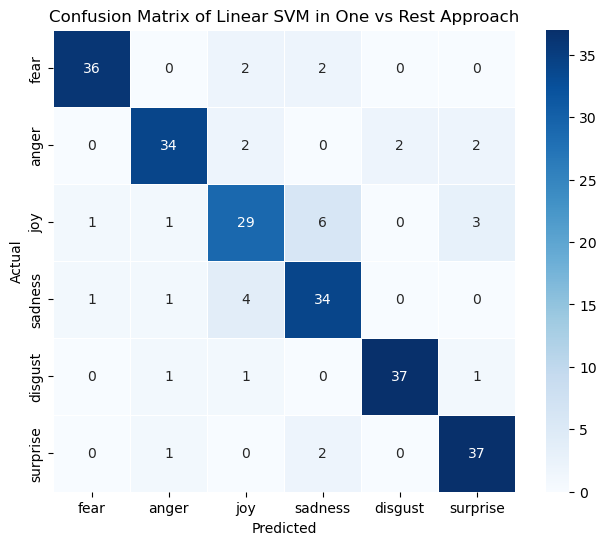

In [76]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Create the confusion matrix
conf_matrix = confusion_matrix(Y_test, Y_pred)

# Convert the confusion matrix to a DataFrame for better visualization
conf_df = pd.DataFrame(conf_matrix, index=class_names.values(), columns=class_names.values())

# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_df, annot=True, fmt='d', cmap='Blues', cbar=True, linewidths=.5, square=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix of Linear SVM in One vs Rest Approach')
plt.show()
